In [1]:
import numpy as np
import torch
from torchvision.datasets import Cityscapes
import os
from glob import glob
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import cv2
from PIL import Image
import imageio
from einops import rearrange
from torchvision import transforms
from torchvision.io import read_image
import torchvision
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from labels import id2label, label2id, id2color

C:\Users\Josh\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Josh\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Josh\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Define Labels
Use KMeans to figure out colors

## Define Dataset

In [2]:
train_label_path = ('cityscapes/gtFine/gtFine/train/aachen')
train_path = ('cityscapes/leftImg8bit/leftImg8bit/train/aachen')
valid_path = glob('cityscapes/gtFine/gtFine/val/*')
test_path = glob('cityscapes/gtFine/gtFine/val/*')

In [3]:
class CropBottomThird(object):
    def __init__(self):
        pass

    def __call__(self, image):
        height, width = image.size()[-2:]
        new_height = height# //2
        print(new_height)
        return transforms.functional.crop(image, 0, 0, new_height, width)

In [53]:
RGB = torchvision.io.ImageReadMode.RGB
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_fns = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        label_fn = image_fn.replace('leftImg8bit', 'gtFine_color')
        
        image_fp = os.path.join(self.image_dir, image_fn)
        label_fp = os.path.join(self.label_dir, label_fn)
        print(image_fp, label_fp)
        original = self.transform(read_image(image_fp) /255.0)
        original = transforms.Resize((1024, 1024))(original)
        
        label = self.transform(read_image(label_fp, RGB) / 255.0)
        
        
        # cityscape = self.transform(cityscape)

        return original, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            CropBottomThird(),
        ])
        return transform_ops(image)

In [54]:
train = CityscapeDataset(train_path, train_label_path)

In [55]:
len(train)

174

In [56]:
cityscape, label_class = train[4]
print(cityscape.shape, label_class.shape)

cityscapes/leftImg8bit/leftImg8bit/train/aachen\aachen_000004_000019_leftImg8bit.png cityscapes/gtFine/gtFine/train/aachen\aachen_000004_000019_gtFine_color.png
1024
1024
torch.Size([3, 1024, 1024]) torch.Size([3, 1024, 2048])


In [35]:
def tensor_to_im(im):
    return rearrange(im, 'C H W -> H W C').numpy()

In [36]:
def display_im(image):
    image = tensor_to_im(image)
    plt.imshow(image)
    plt.show()

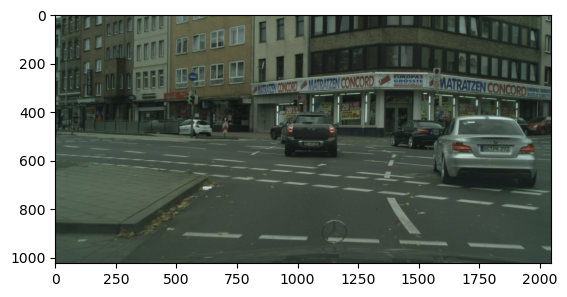

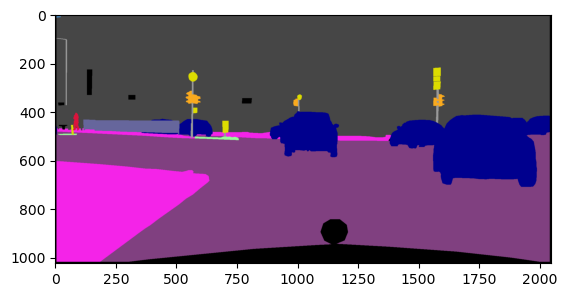

In [37]:
display_im(cityscape)
display_im(label_class)

## Define Color Utils

In [11]:
# These are the colors for various objects in the segmented image
# found at https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
colors = {
 "traffic light": (250,170, 30),
    "traffic sign": (220,220, 0)
}

In [12]:
def display_color(color):
    # Create a 24x24 array of the color
    arr = np.zeros((24, 24, 3), dtype=int)
    arr[:, :] = color
    
    # Display the image using pyplot
    plt.imshow(arr)
    plt.show()

In [13]:
def get_object_mask(object_name, images):
    """
    Takes (batch_size, channels, height, width) image tensor
    """
    color = colors[object_name]
    images = rearrange(images, 'N C H W -> N H W C')
    mask = torch.all(images[:,:,:]==color)
    return rearrange(mask, 'N H W C -> N C H W')

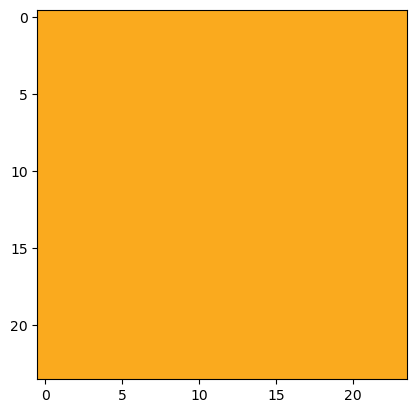

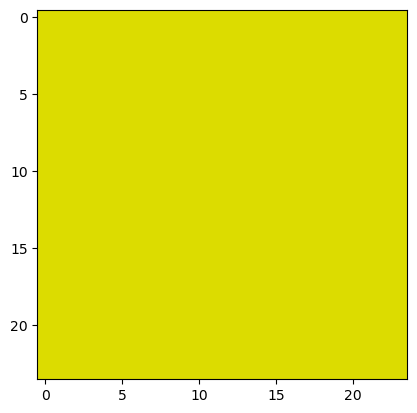

In [14]:
display_color(colors['traffic light'])
display_color(colors['traffic sign'])

## Import Models

In [15]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [16]:
image = cityscape

In [17]:
prompts = ["traffic light", "car"]

In [18]:
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

In [19]:
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

C:\Users\Josh\AppData\Local\Temp\ipykernel_45328\1528053589.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  [ax[i+1].imshow((F.softmax(preds[i][0])> 0.01) * 255) for i in range(len(prompts))];


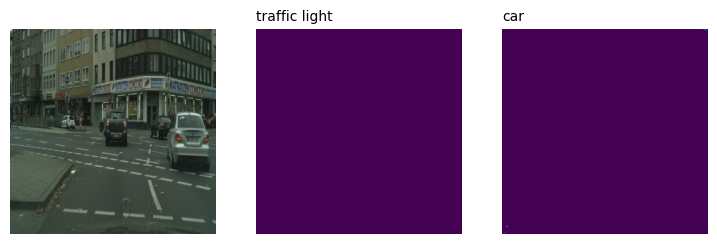

In [20]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(tensor_to_im(image))
[ax[i+1].imshow((F.softmax(preds[i][0])> 0.01) * 255) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [21]:
np.sum((preds[1][0] > 0.4).numpy())

0

In [22]:
torch.sum(F.softmax(preds[1][0])>0.01)

C:\Users\Josh\AppData\Local\Temp\ipykernel_45328\2369647250.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.sum(F.softmax(preds[1][0])>0.01)


tensor(13)

## Define the Model

In [23]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

In [24]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")

C:\Users\Josh\anaconda3\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\Josh\anaconda3\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [60]:
image = cityscape
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

In [61]:
# First, rescale logits to original image size
upsampled_logits = F.interpolate(logits,
                size=(1024,1024), # (height, width)
                mode='bilinear',
                align_corners=False)

In [62]:
upsampled_logits.argmax(dim=1).shape

torch.Size([1, 1024, 1024])

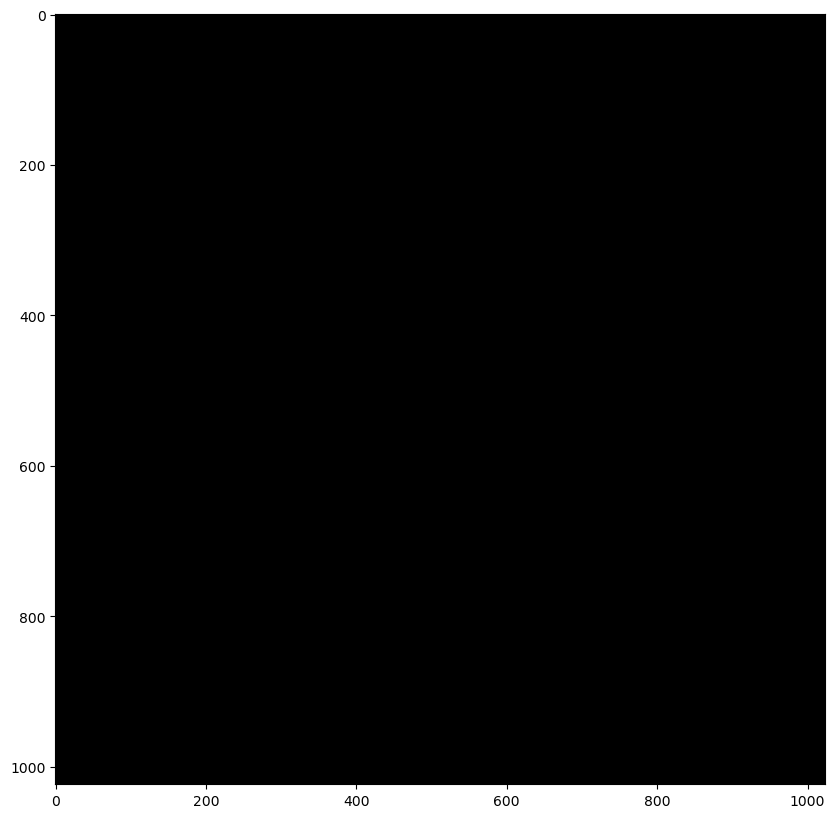

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])

In [63]:
# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1).squeeze(0)
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label_id, color in id2color.items():
    color_seg[seg == label_id, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(rearrange(image, 'C H W -> H W C')) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()
seg